## Load the dataset

In [1]:
!pip install tensorflow



In [2]:
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_lfw_people

faces = fetch_lfw_people(min_faces_per_person=100, resize=1.0, slice_=(slice(60, 188), slice(60, 188)), color=False)
class_count = len(faces.target_names)

print(faces.target_names)
print(faces.images.shape)

['Colin Powell' 'Donald Rumsfeld' 'George W Bush' 'Gerhard Schroeder'
 'Tony Blair']
(1140, 128, 128)


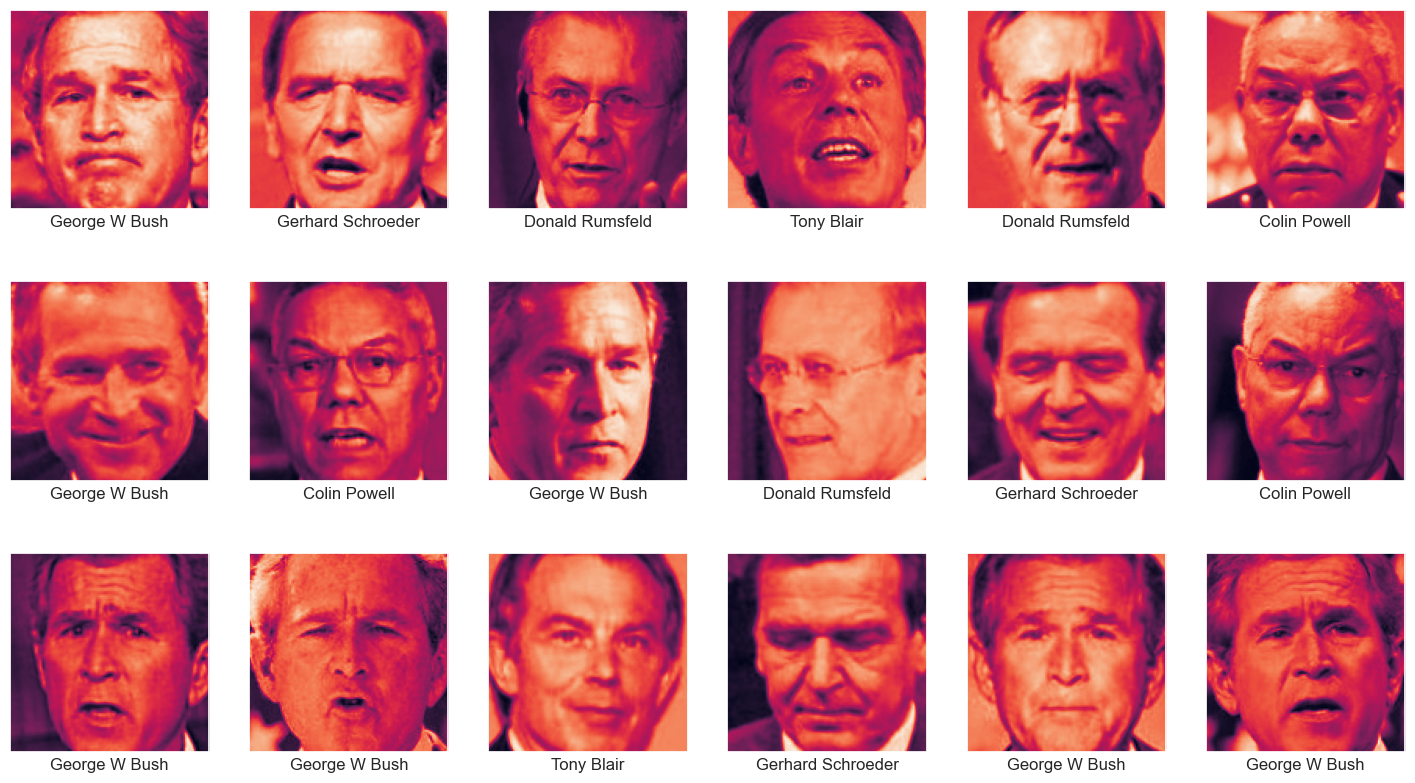

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

fig, ax = plt.subplots(3, 6, figsize=(18, 10))

for i, axi in enumerate(ax.flat):
    axi.imshow(faces.images[i]) # Scale pixel values so Matplotlib doesn't clip everything above 1.0
    axi.set(xticks=[], yticks=[], xlabel=faces.target_names[faces.target[i]])

<Axes: >

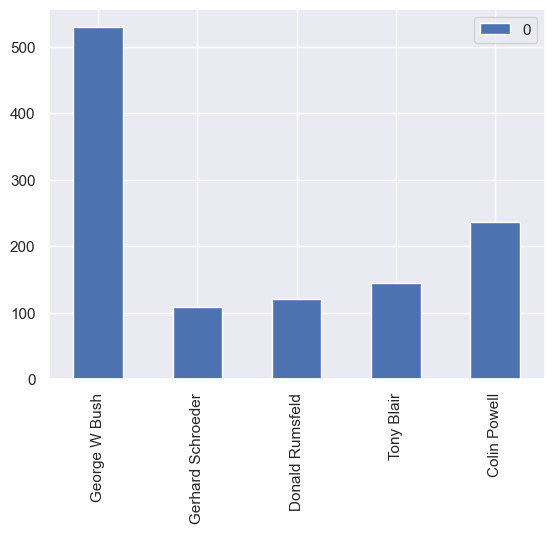

In [4]:
from collections import Counter
counts = Counter(faces.target)
names = {}

for key in counts.keys():
    names[faces.target_names[key]] = counts[key]

df = pd.DataFrame.from_dict(names, orient='index')
df.plot(kind='bar')

In [5]:
mask = np.zeros(faces.target.shape, dtype=np.bool_)

for target in np.unique(faces.target):
    mask[np.where(faces.target == target)[0][:100]] = 1

x_faces = faces.data[mask]
y_faces = faces.target[mask]
x_faces = np.reshape(x_faces, (x_faces.shape[0], faces.images.shape[1], faces.images.shape[2], 1))
x_faces.shape

(500, 128, 128, 1)

2
3
1
4
0


<Axes: >

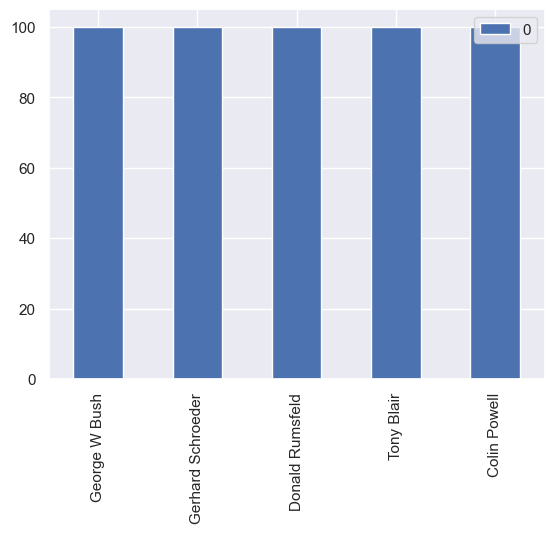

In [6]:
from collections import Counter
counts = Counter(y_faces)
names = {}

for key in counts.keys():
    print(key)
    names[faces.target_names[key]] = counts[key]

df = pd.DataFrame.from_dict(names, orient='index')
df.plot(kind='bar')

In [7]:
!python -m pip install tensorflow

In [8]:
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

face_images = x_faces # Normalize pixel values
face_labels = to_categorical(y_faces)

x_train, x_test, y_train, y_test = train_test_split(face_images, face_labels, test_size=0.15, stratify=face_labels, random_state=42)

## CNN

In [9]:
import time
import tensorflow as tf
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [10]:
# Подготовка модели
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(face_images.shape[1:])),
    MaxPooling2D(2, 2),
    Dropout(0.2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Dropout(0.2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(class_count, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

C:\Users\Den\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 126, 126, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 28, 28, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 12544)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       1,605,760 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │             645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,662,149 (6.34 MB)

 Trainable params: 1,662,149 (6.34 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
# Обучение модели
start_time = time.time()
hist = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=20, batch_size=25)
print("Time for training: {:.2f} seconds".format(time.time() - start_time))


Epoch 1/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.2279 - loss: 1.8781 - val_accuracy: 0.2000 - val_loss: 1.6092
Epoch 2/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.1978 - loss: 1.6086 - val_accuracy: 0.1867 - val_loss: 1.6082
Epoch 3/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.2174 - loss: 1.6060 - val_accuracy: 0.2000 - val_loss: 1.5991
Epoch 4/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.2864 - loss: 1.5755 - val_accuracy: 0.3467 - val_loss: 1.5624
Epoch 5/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.4297 - loss: 1.4480 - val_accuracy: 0.4800 - val_loss: 1.3566
Epoch 6/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.5821 - loss: 1.1462 - val_accuracy: 0.5067 - val_loss: 1.0656
Epoch 7/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.7445 - loss: 0.7789 - val_accuracy: 0.6000 - val_loss: 0.9573
Epoch 8/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.7544 - loss: 0.7123 - val_accuracy: 0.7200 - v

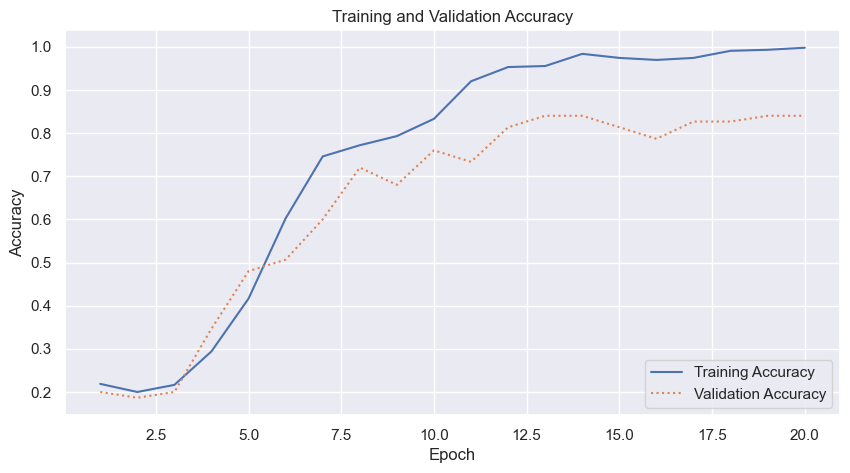

In [12]:
# Графики точности
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
epochs = range(1, len(acc) + 1)
plt.figure(figsize=(10, 5))
plt.plot(epochs, acc, '-', label='Training Accuracy')
plt.plot(epochs, val_acc, ':', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


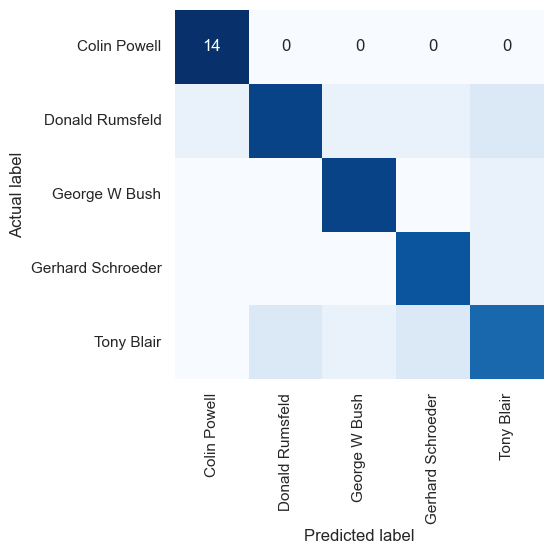

In [13]:
# Построение матрицы ошибок
y_pred = model.predict(x_test).argmax(axis=1)
y_true = y_test.argmax(axis=1)
mat = confusion_matrix(y_true, y_pred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, cmap='Blues',
            xticklabels=faces.target_names,
            yticklabels=faces.target_names)
plt.xlabel('Predicted label')
plt.ylabel('Actual label')
plt.show()

In [14]:
# Отчет классификации
print(classification_report(y_true, y_pred, target_names=faces.target_names))

                   precision    recall  f1-score   support

     Colin Powell       1.00      0.93      0.97        15
  Donald Rumsfeld       0.72      0.87      0.79        15
    George W Bush       0.93      0.87      0.90        15
Gerhard Schroeder       0.92      0.80      0.86        15
       Tony Blair       0.69      0.73      0.71        15

         accuracy                           0.84        75
        macro avg       0.85      0.84      0.84        75
     weighted avg       0.85      0.84      0.84        75



In [15]:
import tensorflow as tf

# Расчет FLOPs
def get_flops(model):
    # Подготавливаем конкретную функцию модели
    concrete_func = tf.function(lambda inputs: model(inputs)).get_concrete_function(
        [tf.TensorSpec([1, *input.shape[1:]], input.dtype) for input in model.inputs])

    # Применяем функцию convert_variables_to_constants_v2
    from tensorflow.python.framework.convert_to_constants import convert_variables_to_constants_v2
    frozen_func = convert_variables_to_constants_v2(concrete_func)
    graph_def = frozen_func.graph.as_graph_def()

    # Создаем новый граф для подсчета FLOPs
    with tf.Graph().as_default() as graph:
        tf.import_graph_def(graph_def, name='')
        run_meta = tf.compat.v1.RunMetadata()
        opts = tf.compat.v1.profiler.ProfileOptionBuilder.float_operation()
        flops = tf.compat.v1.profiler.profile(graph=graph, run_meta=run_meta, cmd='op', options=opts)

    return flops.total_float_ops

print(f"FLOPs: {get_flops(model)}")




Instructions for updating:
This API was designed for TensorFlow v1. See https://www.tensorflow.org/guide/migrate for instructions on how to migrate your code to TensorFlow v2.
FLOPs: 208915934


In [16]:
# Измерение времени инференса
start_time = time.time()
model.predict(x_test[:1])
print("Time for a single prediction: {:.2f} milliseconds".format((time.time() - start_time) * 1000))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Time for a single prediction: 35.89 milliseconds


In [17]:
# Расчет общего числа параметров
total_params = model.count_params()
print("Total parameters: {}".format(total_params))

Total parameters: 1662149


In [18]:
!pip install memory_profiler


In [19]:
# Использование memory_profiler для измерения памяти
from memory_profiler import memory_usage

def predict():
    model.predict(x_test[:10])

mem_usage = memory_usage(predict)
print("Peak memory usage: {:.2f} MiB".format(max(mem_usage)))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Peak memory usage: 1027.75 MiB


## Pretrain VGG16

In [20]:
# Загружаем датасет Labeled Faces in the Wild (LFW) с использованием функции fetch_lfw_people из библиотеки scikit-learn.
# Указываем параметры для фильтрации данных:
# min_faces_per_person=100 - выбираем только тех людей, у которых в датасете есть 100 и более изображений,
# что помогает улучшить качество распознавания за счет более крупных и сбалансированных наборов данных по каждому классу.
# resize=1.0 - сохраняем оригинальный размер изображений, не применяя масштабирование.
# slice_=(slice(60, 188), slice(60, 188)) - обрезаем изображения до указанной области,
# что может помочь сосредоточить внимание модели на более релевантных частях лица, например, исключая фон.
# color=True - загружаем изображения в цвете, что может предоставить дополнительную информацию для распознавания по сравнению с градациями серого.
faces = fetch_lfw_people(min_faces_per_person=100, resize=1.0, slice_=(slice(60, 188), slice(60, 188)), color=True)

# Вычисляем количество уникальных классов (лиц) в датасете, используя атрибут target_names объекта датасета.
# Это значение будет использоваться для определения количества выходных нейронов в модели классификации и для
# интерпретации результатов распознавания.
class_count = len(faces.target_names)

In [21]:
mask = np.zeros(faces.target.shape, dtype=np.bool_)

for target in np.unique(faces.target):
    mask[np.where(faces.target == target)[0][:100]] = 1

x_faces = faces.data[mask]
y_faces = faces.target[mask]
x_faces = np.reshape(x_faces, (x_faces.shape[0], faces.images.shape[1], faces.images.shape[2], faces.images.shape[3]))
x_faces.shape

(500, 128, 128, 3)

In [22]:
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

face_images = x_faces # Normalize pixel values
face_labels = to_categorical(y_faces)

x_train, x_test, y_train, y_test = train_test_split(face_images, face_labels, test_size=0.15, stratify=face_labels, random_state=42)

In [23]:
import numpy as np

# Преобразование монохромных изображений (128, 128) в цветные (128, 128, 3)
x_train_rgb = np.tile(x_train[..., None], (1, 1, 1, 3))
x_test_rgb = np.tile(x_test[..., None], (1, 1, 1, 3))


In [24]:
# Импортируем функцию to_categorical из TensorFlow, которая используется для преобразования целочисленных меток в one-hot кодированные метки.
from tensorflow.keras.utils import to_categorical
# Импортируем функцию train_test_split из sklearn, предназначенную для разделения данных на обучающий и тестовый наборы.
from sklearn.model_selection import train_test_split

# Создаем переменную face_images, которая ссылается на данные изображений лиц. В комментарии упомянуто о нормализации
# значений пикселей, однако сам процесс нормализации здесь не производится. Нормализация обычно включает деление
# значений пикселей на 255 для преобразования их в диапазон от 0 до 1, что улучшает процесс обучения нейронной сети.
face_images = x_faces # Эта строка сама по себе не производит нормализацию пикселей.

# Преобразуем метки классов y_faces в формат one-hot, используя функцию to_categorical.
# Это преобразование необходимо, так как многие алгоритмы машинного обучения, включая нейронные сети,
# лучше работают с данными, представленными в виде векторов one-hot.
face_labels = to_categorical(y_faces)

# Разделяем набор данных на обучающую и тестовую выборки, используя функцию train_test_split.
# test_size=0.15 указывает, что 15% данных будут использованы как тестовый набор.
# Параметр stratify гарантирует, что в обучающей и тестовой выборках будет одинаковое распределение классов,
# что важно для поддержания сбалансированности данных.
# Параметр random_state=42 обеспечивает воспроизводимость разделения данных, позволяя получать одинаковое разделение при каждом выполнении кода.
x_train, x_test, y_train, y_test = train_test_split(face_images, face_labels, test_size=0.15, stratify=face_labels, random_state=42)

In [26]:
from tensorflow.keras.applications import VGG16


In [27]:
#vgg 16 model
classifier_vgg16 = VGG16(input_shape= (128, 128, 3),include_top=False,weights='imagenet')
classifier_vgg16.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 128, 128, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 128, 128, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 64, 64, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 64, 64, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 32, 32, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 32, 32, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 32, 32, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 16, 16, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 16, 16, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 8, 8, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 4, 4, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [28]:
#not train top layers
for layer in classifier_vgg16.layers:
    layer.trainable = False

In [30]:
from tensorflow.keras.layers import GlobalAveragePooling2D


In [31]:
#adding extra layers for our class/images
main_model = classifier_vgg16.output
main_model = GlobalAveragePooling2D()(main_model)
main_model = Dense(1024,activation='relu')(main_model)
main_model = Dense(1024,activation='relu')(main_model)
main_model = Dense(512,activation='relu')(main_model)
main_model = Dropout(0.5)(main_model)
main_model = Dense(5,activation='softmax')(main_model)

In [33]:
from tensorflow.keras.models import Model


In [34]:
#compiling
model = Model(inputs = classifier_vgg16.input , outputs = main_model)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
             


In [35]:
hist = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=20, batch_size=25)

Epoch 1/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 176ms/step - accuracy: 0.1814 - loss: 1.7832 - val_accuracy: 0.3733 - val_loss: 1.5374
Epoch 2/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 159ms/step - accuracy: 0.3418 - loss: 1.4989 - val_accuracy: 0.4267 - val_loss: 1.4183
Epoch 3/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 159ms/step - accuracy: 0.5219 - loss: 1.2106 - val_accuracy: 0.5600 - val_loss: 1.0940
Epoch 4/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 160ms/step - accuracy: 0.6646 - loss: 0.8711 - val_accuracy: 0.6400 - val_loss: 0.9645
Epoch 5/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 159ms/step - accuracy: 0.7595 - loss: 0.6859 - val_accuracy: 0.7467 - val_loss: 0.7543
Epoch 6/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 159ms/step - accuracy: 0.8371 - loss: 0.4922 - val_accuracy: 0.6533 - val_loss: 1.0320
Epoch 7/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 159ms/step - accuracy: 0.7978 - loss: 0.4942 - val_accuracy: 0.8133 - val_loss: 0.6935
Epoch 8/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 162ms/step - accuracy: 0.9231 - loss: 0.2781 - val_accuracy: 0.

[]

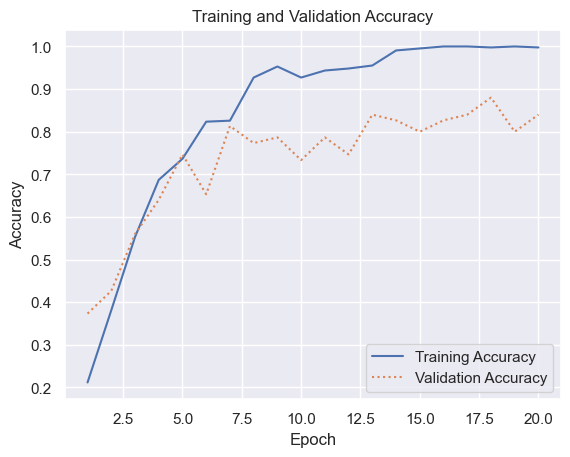

In [36]:
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, '-', label='Training Accuracy')
plt.plot(epochs, val_acc, ':', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.plot()


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 159ms/step


Text(110.44999999999996, 0.5, 'Actual label')

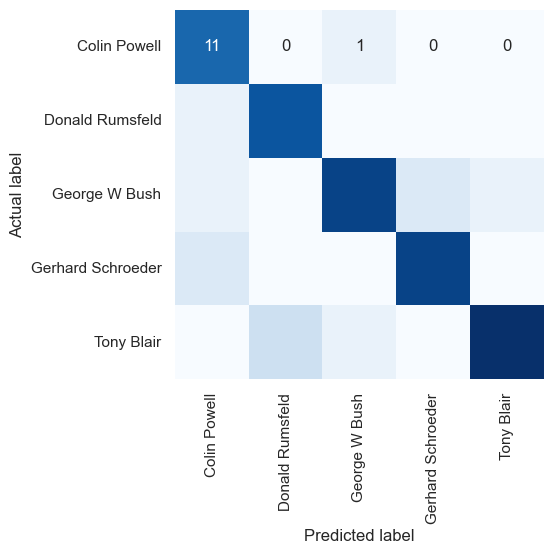

In [37]:
from sklearn.metrics import confusion_matrix

y_predicted = model.predict(x_test)
mat = confusion_matrix(y_test.argmax(axis=1), y_predicted.argmax(axis=1))

sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, cmap='Blues',
            xticklabels=faces.target_names,
            yticklabels=faces.target_names)

plt.xlabel('Predicted label')
plt.ylabel('Actual label')

In [38]:
# Функция подсчета FLOPs
import tensorflow as tf

def get_flops(model):
    concrete_func = tf.function(lambda inputs: model(inputs)).get_concrete_function(
        [tf.TensorSpec([1, *input.shape[1:]], input.dtype) for input in model.inputs])
    from tensorflow.python.framework.convert_to_constants import convert_variables_to_constants_v2
    frozen_func = convert_variables_to_constants_v2(concrete_func)
    graph_def = frozen_func.graph.as_graph_def()
    with tf.Graph().as_default() as graph:
        tf.import_graph_def(graph_def, name='')
        run_meta = tf.compat.v1.RunMetadata()
        opts = tf.compat.v1.profiler.ProfileOptionBuilder.float_operation()
        flops = tf.compat.v1.profiler.profile(graph=graph, run_meta=run_meta, cmd='op', options=opts)
    return flops.total_float_ops

print(f"FLOPs: {get_flops(model)}")

FLOPs: 10032922142


In [39]:
#Расчет FLOPs:
def get_flops(model):
    concrete_func = tf.function(lambda inputs: model(inputs)).get_concrete_function(
        [tf.TensorSpec([1, *input.shape[1:]], input.dtype) for input in model.inputs])
    from tensorflow.python.framework.convert_to_constants import convert_variables_to_constants_v2
    frozen_func = convert_variables_to_constants_v2(concrete_func)
    graph_def = frozen_func.graph.as_graph_def()
    with tf.Graph().as_default() as graph:
        tf.compat.v1.import_graph_def(graph_def, name='')
        run_meta = tf.compat.v1.RunMetadata()
        opts = tf.compat.v1.profiler.ProfileOptionBuilder.float_operation()
        flops = tf.compat.v1.profiler.profile(graph=graph, run_meta=run_meta, cmd='op', options=opts)
    return flops.total_float_ops

print(f"FLOPs: {get_flops(model)}")



FLOPs: 10032922142


In [40]:
# Измерение времени инференса:
start_time = time.time()
model.predict(x_test[:1])
print("Time for a single prediction: {:.2f} milliseconds".format((time.time() - start_time) * 1000))



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Time for a single prediction: 46.29 milliseconds


In [41]:
#Расчет общего числа параметров:
total_params = model.count_params()
print("Total parameters: {}".format(total_params))


Total parameters: 16816965


In [42]:
# Измерение памяти:
def predict():
    model.predict(x_test[:10])

mem_usage = memory_usage(predict)
print("Peak memory usage: {:.2f} MiB".format(max(mem_usage)))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
Peak memory usage: 2594.66 MiB


## ResNet50 and ImageNet weights

In [43]:
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_lfw_people

faces = fetch_lfw_people(min_faces_per_person=100, resize=1.0, slice_=(slice(60, 188), slice(60, 188)), color=True)
class_count = len(faces.target_names)

print(faces.target_names)
print(faces.images.shape)

['Colin Powell' 'Donald Rumsfeld' 'George W Bush' 'Gerhard Schroeder'
 'Tony Blair']
(1140, 128, 128, 3)


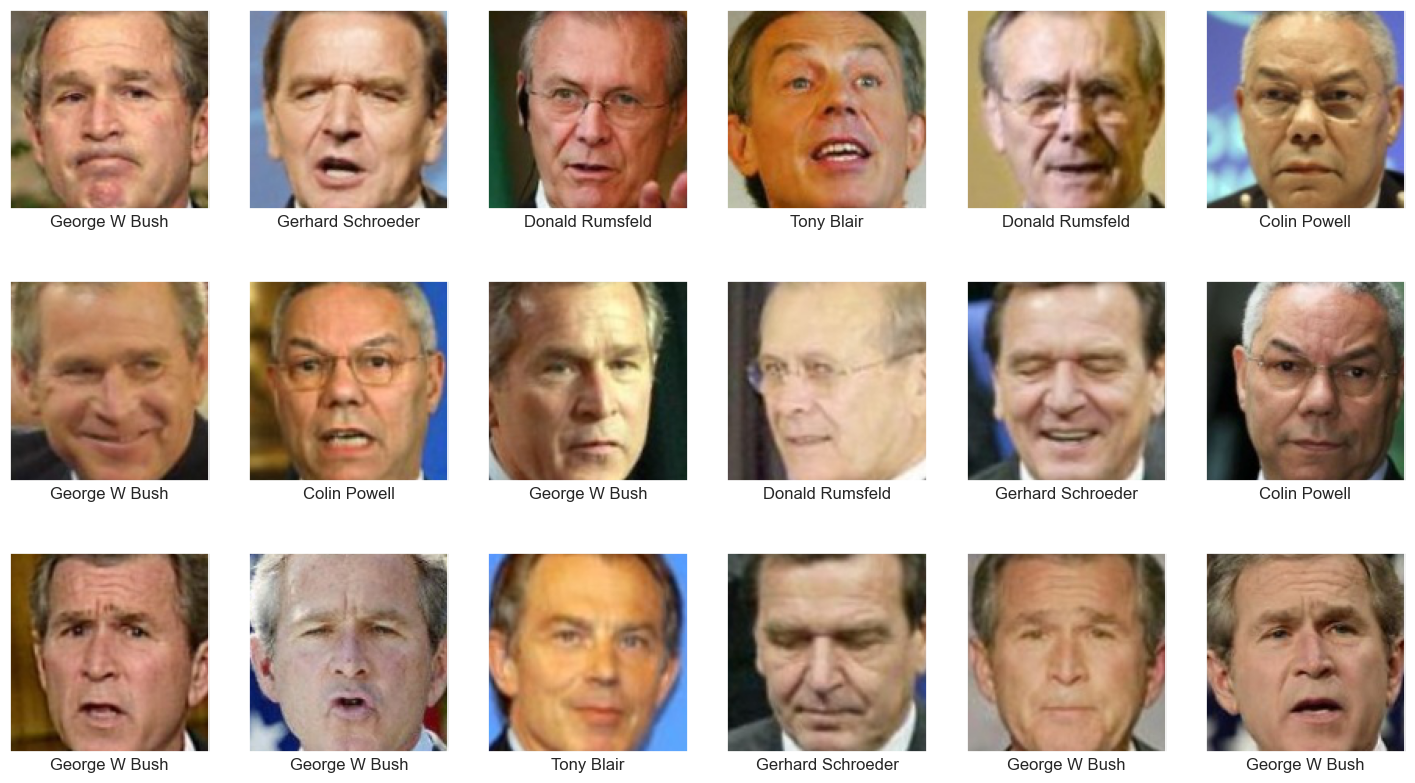

In [44]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

fig, ax = plt.subplots(3, 6, figsize=(18, 10))

for i, axi in enumerate(ax.flat):
    axi.imshow(faces.images[i]) # Scale pixel values so Matplotlib doesn't clip everything above 1.0
    axi.set(xticks=[], yticks=[], xlabel=faces.target_names[faces.target[i]])

In [45]:
mask = np.zeros(faces.target.shape, dtype=np.bool_)

for target in np.unique(faces.target):
    mask[np.where(faces.target == target)[0][:100]] = 1

x_faces = faces.data[mask]
y_faces = faces.target[mask]
x_faces = np.reshape(x_faces, (x_faces.shape[0], faces.images.shape[1], faces.images.shape[2], faces.images.shape[3]))
x_faces.shape

(500, 128, 128, 3)

In [46]:
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications.resnet50 import preprocess_input
from sklearn.model_selection import train_test_split

face_images = preprocess_input(np.array(x_faces))
face_labels = to_categorical(y_faces)

x_train, x_test, y_train, y_test = train_test_split(face_images, face_labels, train_size=0.8, stratify=face_labels, random_state=0)


In [47]:
from tensorflow.keras.applications import ResNet50

base_model = ResNet50(weights='imagenet', include_top=False)
base_model.trainable = False

In [48]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Resizing

model = Sequential()
model.add(Resizing(224, 224))
model.add(base_model)
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dense(class_count, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [49]:
hist = model.fit(x_train, y_train, validation_data=(x_test, y_test), batch_size=25, epochs=20)

Epoch 1/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 15s 636ms/step - accuracy: 0.1957 - loss: 30.5830 - val_accuracy: 0.2000 - val_loss: 4.0698
Epoch 2/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 9s 553ms/step - accuracy: 0.2426 - loss: 3.8505 - val_accuracy: 0.2000 - val_loss: 3.4285
Epoch 3/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 9s 552ms/step - accuracy: 0.2077 - loss: 2.5492 - val_accuracy: 0.2800 - val_loss: 2.0759
Epoch 4/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 9s 552ms/step - accuracy: 0.2853 - loss: 1.9505 - val_accuracy: 0.2000 - val_loss: 1.6596
Epoch 5/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 9s 547ms/step - accuracy: 0.3244 - loss: 1.5631 - val_accuracy: 0.2100 - val_loss: 1.8007
Epoch 6/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 9s 542ms/step - accuracy: 0.3055 - loss: 1.7104 - val_accuracy: 0.4200 - val_loss: 1.6784
Epoch 7/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 9s 542ms/step - accuracy: 0.3426 - loss: 1.5251 - val_accuracy: 0.2700 - val_loss: 1.6525
Epoch 8/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 9s 543ms/step - accuracy: 0.3705 - loss: 1.4771 - val_accuracy: 

[]

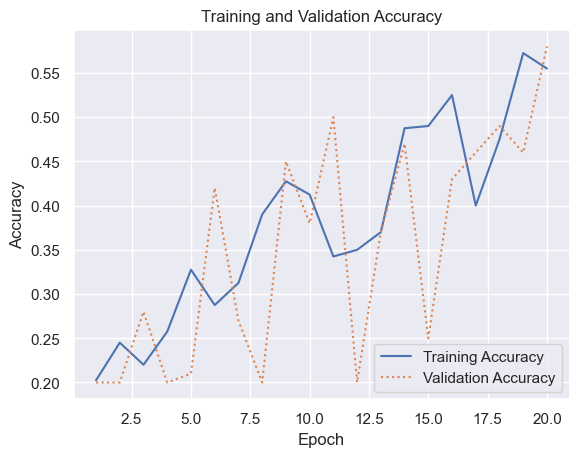

In [50]:
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, '-', label='Training Accuracy')
plt.plot(epochs, val_acc, ':', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.plot()

In [51]:
#Расчет FLOPs:
def get_flops(model):
    concrete_func = tf.function(lambda inputs: model(inputs)).get_concrete_function(
        [tf.TensorSpec([1, *input.shape[1:]], input.dtype) for input in model.inputs])
    from tensorflow.python.framework.convert_to_constants import convert_variables_to_constants_v2
    frozen_func = convert_variables_to_constants_v2(concrete_func)
    graph_def = frozen_func.graph.as_graph_def()
    with tf.Graph().as_default() as graph:
        tf.compat.v1.import_graph_def(graph_def, name='')
        run_meta = tf.compat.v1.RunMetadata()
        opts = tf.compat.v1.profiler.ProfileOptionBuilder.float_operation()
        flops = tf.compat.v1.profiler.profile(graph=graph, run_meta=run_meta, cmd='op', options=opts)
    return flops.total_float_ops

print(f"FLOPs: {get_flops(model)}")

FLOPs: 7956629150


In [52]:
# Измерение времени инференса:
start_time = time.time()
model.predict(x_test[:1])
print("Time for a single prediction: {:.2f} milliseconds".format((time.time() - start_time) * 1000))

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Time for a single prediction: 1422.39 milliseconds


In [53]:
#Расчет общего числа параметров:
total_params = model.count_params()
print("Total parameters: {}".format(total_params))

Total parameters: 126354309


In [54]:
# Измерение памяти:
def predict():
    model.predict(x_test[:10])

mem_usage = memory_usage(predict)
print("Peak memory usage: {:.2f} MiB".format(max(mem_usage)))

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Peak memory usage: 4961.51 MiB
